# Import Libraries

In [1]:
# data manipulation
import pandas as pd

# numpy arrays
import numpy as np

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

sns.set()

# NLP
import string

import spacy
from spacy.tokens.doc import Doc
from spacy.matcher import Matcher

from wordcloud import WordCloud

import nltk
from nltk.probability import FreqDist

import re

# machine learning
from sklearn.datasets import fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# TODO:
# install the latest version of `sklearn` to use `plot_confusion_matrix` 
# from sklearn.metrics import plot_confusion_matrix

nlp = spacy.load('en_core_web_md')

# Helper Functions

In [2]:
def get_n_color_palette(palette_name, n_colors, as_hex=False):
    palette = sns.color_palette(palette=palette_name, n_colors=n_colors)
    if as_hex:
        palette = palette.as_hex()
    palette.reverse()
    return palette

# Load and Prepare Data

For faster execution times, select subset of the categories out of the 20 categories

In [3]:
subset_categories = ['alt.atheism', 'soc.religion.christian',
              'comp.graphics', 'sci.med']

In [4]:
newsgroups_data = fetch_20newsgroups(subset='all', categories=subset_categories)

In [5]:
categories = newsgroups_data.target_names

In [6]:
df = pd.DataFrame(data={
    'text': newsgroups_data.data,
    'category': newsgroups_data.target
})

In [7]:
df.shape

(3759, 2)

In [8]:
df['category'] = df['category'].apply(lambda x: categories[x])

In [9]:
df.head()

,text,category
0,From: geb@cs.pitt.edu (Gordon Banks)\nSubject:...,sci.med
1,From: swf@elsegundoca.ncr.com (Stan Friesen)\n...,soc.religion.christian
2,From: David.Bernard@central.sun.com (Dave Bern...,soc.religion.christian
3,From: hotopp@ami1.bwi.wec.com (Daniel T. Hotop...,comp.graphics
4,From: billc@col.hp.com (Bill Claussen)\nSubjec...,sci.med


# What is this Data?

The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups.

The data is organized into 20 different newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related to each other (e.g. `comp.sys.ibm.pc.hardware` / `comp.sys.mac.hardware`), while others are highly unrelated (e.g `misc.forsale` / `soc.religion.christian`).

Here is a list of the 20 newsgroups, partitioned (more or less) according to subject matter:

<table style='font-family:"Courier New", Courier, monospace; font-size:80%'>
    <tr>
        <td>comp.graphics<br>comp.os.ms-windows.misc<br>comp.sys.ibm.pc.hardware<br>comp.sys.mac.hardware<br>comp.windows.x
        </td>
        <td>rec.autos<br>rec.motorcycles<br>rec.sport.baseball<br>rec.sport.hockey</td>
        <td>sci.crypt<br>sci.electronics<br>sci.med<br>sci.space</td>
    </tr>
    <tr>
        <td>misc.forsale</td>
        <td>talk.politics.misc<br>talk.politics.guns<br>talk.politics.mideast</td>
        <td>talk.religion.misc<br>alt.atheism<br>soc.religion.christian</td>
    </tr>
</table>

# Data Statistics

In [10]:
categories_statistics_df = df.groupby(by='category')['text'].agg({
                                'count': lambda x: x.size,
                                'mean': lambda x: x.str.len().mean(),
                                'max': lambda x: x.str.len().max(),
                                'min': lambda x: x.str.len().min()
                            })\
                            .reset_index()\
                            .sort_values(by='count', ascending=False)

/home/resaln/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version



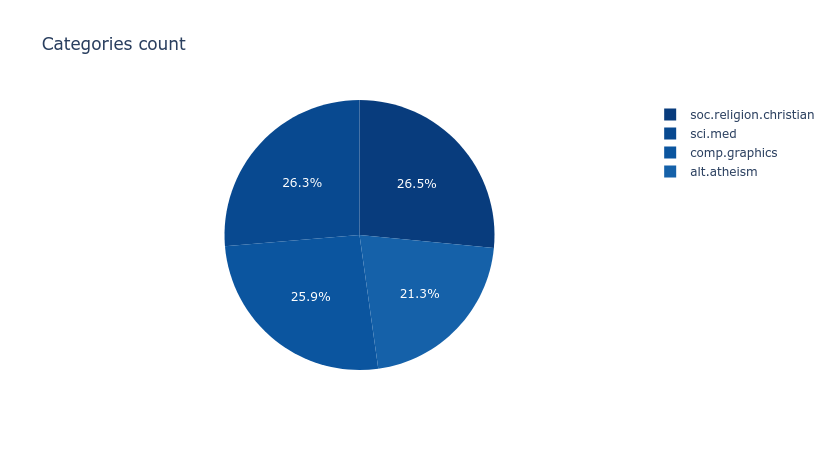

In [11]:
fig = px.pie(data_frame=categories_statistics_df, names='category', values='count',
            color_discrete_sequence=get_n_color_palette('Blues', 20, True),
            title='Categories count')
fig.show()

It's obvious that the dataset is *balanced*

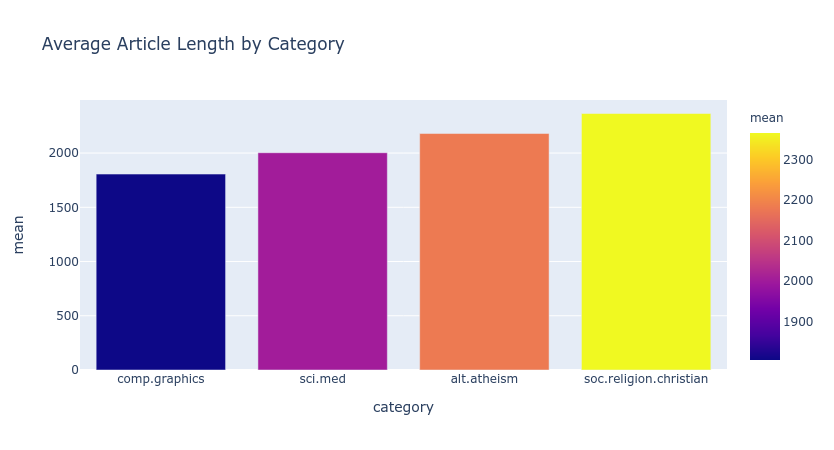

In [12]:
fig = px.bar(data_frame=categories_statistics_df.sort_values(by='mean'), x='category', y='mean',
            color='mean', title='Average Article Length by Category')
fig.show()

This chart shows how long the *polictics* articles, compared to *computer* articles

# Word Cloud

In [13]:
en_stop_words = nlp.Defaults.stop_words

In [14]:
categories_text_df = df.groupby(by='category')\
                        .agg({
                            'text': ' '.join
                        })\
                        .reset_index()

In [15]:
categories_text_df

,category,text
0,alt.atheism,From: vdp@mayo.edu (Vinayak Dutt)\nSubject: Re...
1,comp.graphics,From: hotopp@ami1.bwi.wec.com (Daniel T. Hotop...
2,sci.med,From: geb@cs.pitt.edu (Gordon Banks)\nSubject:...
3,soc.religion.christian,From: swf@elsegundoca.ncr.com (Stan Friesen)\n...


In [16]:
def plot_word_cloud(category_name, category_text):
    plt.subplots(figsize = (8,8))
    wc = WordCloud(background_color="white", stopwords=en_stop_words, width=1000, height=600)
    wc.generate(category_text)
    plt.title(label=category_name)
    plt.axis("off")
    plt.imshow(wc, interpolation="bilinear")
    plt.show()

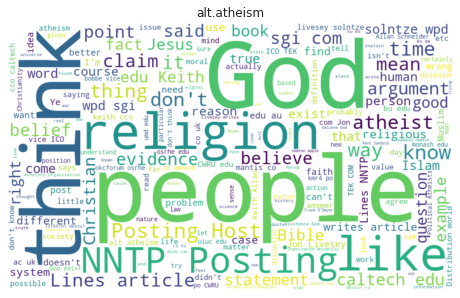

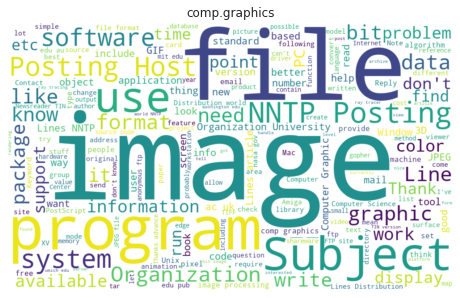

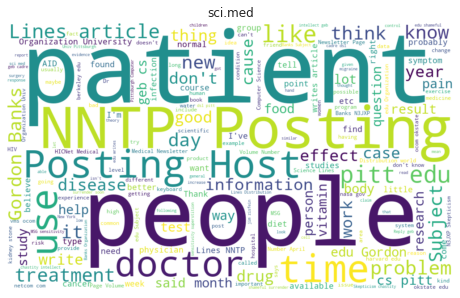

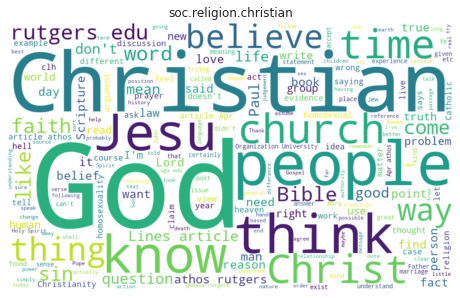

In [17]:
for category in categories:
    plot_word_cloud(category,
               categories_text_df[categories_text_df['category'] == category]['text'].values[0])

# Split the data

In [18]:
X = df['text']
y = df['category']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Text Vectorization

In [20]:
def is_clean_token(token):
    return (
        not token.is_stop                   # remove stop words
        and not token.is_digit              # remove digits
        and not token.like_num              # remove numbers
        and not token.like_email            # remove emails
        and not token.like_url              # remove URLs
        and token.is_alpha                  # keep only alphabetic tokens
        and token.is_ascii                  # keep only ascii tokens
        and len(token.lemma_.lower()) > 2   # keep only token which has length greater than two letters
    )

In [21]:
def spacy_analyzer(document):
    
    # apply the language pipeline on the passed document
    doc = nlp(document)
    
    # clean document
    tokens = [token.lemma_.lower() for token in doc if is_clean_token(token)] 
    
    return tokens

# Create Pipeline

In [22]:
vectorizer = TfidfVectorizer(analyzer=spacy_analyzer)
clf = LogisticRegression(solver='newton-cg', multi_class='multinomial')

In [23]:
pipeline = Pipeline([
    ('vect', vectorizer),
    ('clf', clf)
])

In [24]:
%%time
pipeline.fit(X_train, y_train)

CPU times: user 2min 58s, sys: 4.6 s, total: 3min 2s
Wall time: 3min


Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer=<function spacy_analyzer at 0x7f772f4f0510>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 s...
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=Tr

In [25]:
%%time
y_pred = pipeline.predict(X_test)

CPU times: user 55.9 s, sys: 567 ms, total: 56.4 s
Wall time: 56.4 s


# Evaluation

## Classification report:

In [26]:
clf_report = classification_report(y_true=y_test, y_pred=y_pred,
                                   target_names=pipeline.named_steps.clf.classes_,
                                   output_dict=True)

In [27]:
clf_report_df = pd.DataFrame(data=clf_report)

In [28]:
clf_report_df

,alt.atheism,comp.graphics,sci.med,soc.religion.christian,accuracy,macro avg,weighted avg
f1-score,0.921833,0.967871,0.977956,0.949219,0.956383,0.954220,0.955796
precision,1.000000,0.945098,0.972112,0.923954,0.956383,0.960291,0.958305
recall,0.855000,0.991770,0.983871,0.975904,0.956383,0.951636,0.956383
support,200.000000,243.000000,248.000000,249.000000,0.956383,940.000000,940.000000


In [29]:
clf_report_df.drop(index='support', inplace=True)

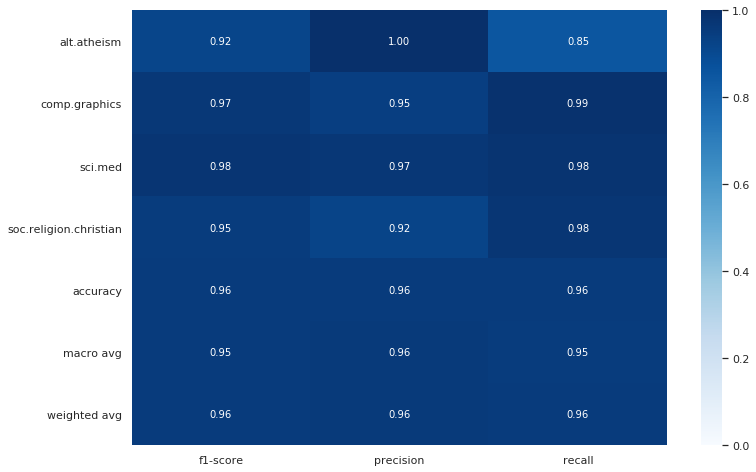

In [30]:
fig = plt.figure(figsize=(12, 8))
sns.heatmap(data=clf_report_df.T, annot=True, cmap='Blues', fmt='.2f', vmin=0, vmax=1)
plt.show()

## Confusion matrix:

In [31]:
conf_matrix = confusion_matrix(y_true=y_test,
                     y_pred=y_pred,
                     labels=pipeline.named_steps.clf.classes_)

In [32]:
conf_matrix_df = pd.DataFrame(data=conf_matrix, columns=pipeline.named_steps.clf.classes_,
                                index=pipeline.named_steps.clf.classes_)

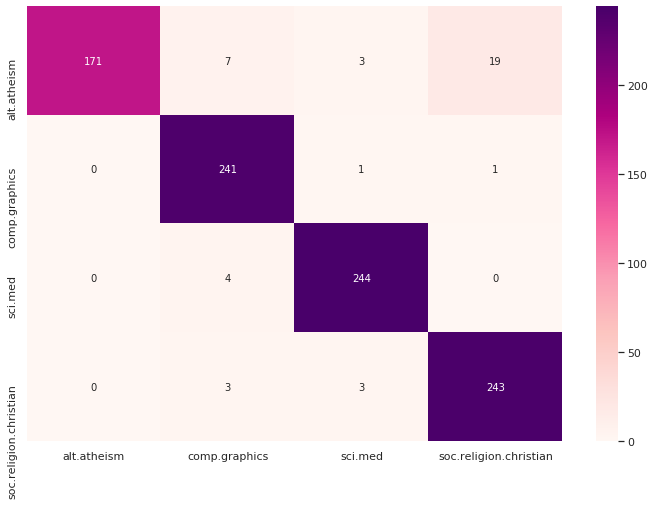

In [33]:
fig = plt.figure(figsize=(12, 8))
sns.heatmap(data=conf_matrix_df, annot=True, cmap='RdPu', fmt='d')
plt.show()

# Features Importance

In [83]:
logistic_regression = pipeline.named_steps['clf']

In [84]:
feature_names = pipeline.named_steps['vect'].get_feature_names()

In [85]:
def plot_features_importance(clf, feature_names, n_feature=15):
    '''
    this function takes the classifier object (assuming it has `coef_` attribute)
    the list of features, which we can get using the vectorizer,
    and the number of features we want to show
    it plots for each class label, the most positive and negative features, with their weight
    '''
    
    for i, class_label in enumerate(clf.classes_):
        
        # get indices of top positive/negative coefficient
        negative_coefs_indices = np.argsort(clf.coef_[i])[:n_feature]
        positive_coefs_indices = np.argsort(clf.coef_[i])[-n_feature:]
        
        # get the coefficient values
        negative_coefs = [clf.coef_[i][coef_idx] for coef_idx in negative_coefs_indices]
        positive_coefs = [clf.coef_[i][coef_idx] for coef_idx in positive_coefs_indices]
        
        # get the corresponding features names of the top coefficient
        negative_features = [feature_names[coef_idx] for coef_idx in negative_coefs_indices]
        positive_features = [feature_names[coef_idx] for coef_idx in positive_coefs_indices]
        
        # stack arrays into one array
        coefs = np.hstack([negative_coefs, positive_coefs])
        features = np.hstack([negative_features, positive_features])
        
        # plot feature names agains their weight, using bar plot
        fig = px.bar(x=features, y=coefs, color=coefs, title=class_label)
        fig.show()

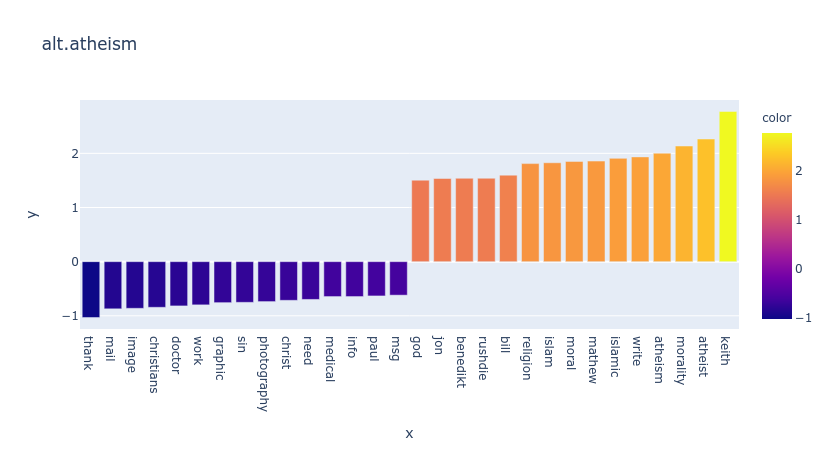

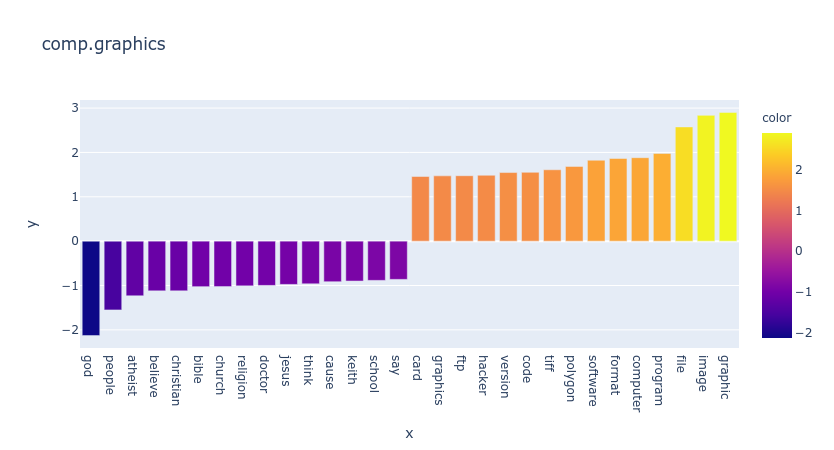

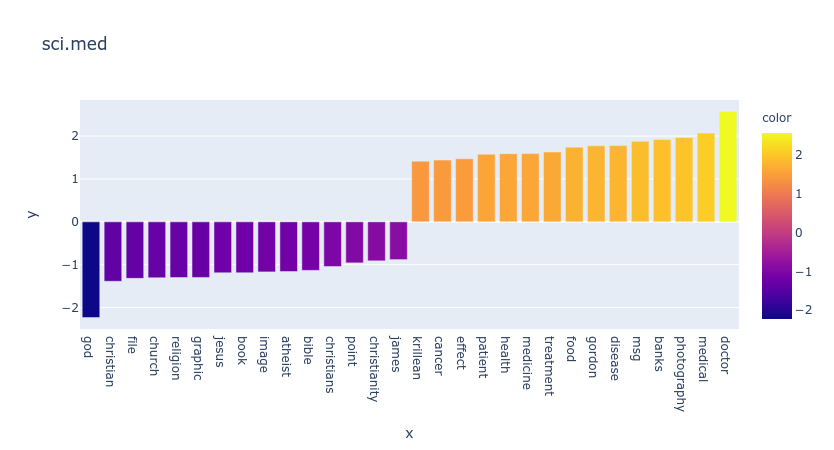

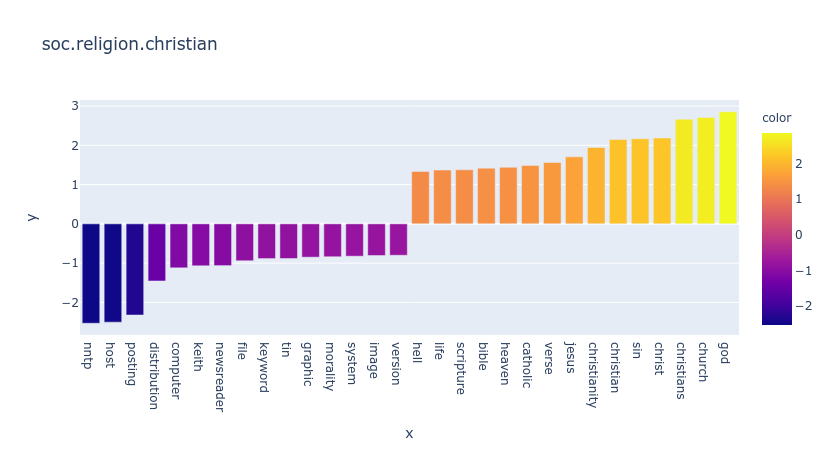

In [86]:
plot_features_importance(clf=clf, feature_names=feature_names)